# Importaciones

In [1]:
!pip install -q gensim evaluate transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import torch, os, zipfile, chardet, spacy, gensim, umap


from evaluate import load
from gensim.models import Word2Vec
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

Usando: cuda


# Dataset cargado limpiado

In [3]:
# Descomprimir el archivo zip
def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data("bbc-train.zip", ".")
unzip_data("bbc-test.zip", ".")

In [4]:
# Cargar datos desde carpetas
def load_data(data_path):
    categories = ["business", "entertainment", "politics", "sports", "tech"]
    data = []

    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        return result['encoding']

    for category in categories:
        folder_path = os.path.join(data_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors="replace") as f:
                text = f.read()
                data.append((text, category))

    return pd.DataFrame(data, columns=["text", "category"])

# Cargar conjuntos de entrenamiento y test
df_train = load_data("bbc-train/")
df_test = load_data("bbc-test/")

In [5]:
# Preprocesamiento con spaCy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

df_train["tokens_2"] = df_train["text"].apply(preprocess_text)
df_test["tokens_2"] = df_test["text"].apply(preprocess_text)

In [6]:
df_train.head()

,text,category,tokens_2
0,Call centre users 'lose patience'\n\nCustomers...,business,"[centre, user, lose, patience, customer, try, ..."
1,Saudi NCCI's shares soar\n\nShares in Saudi Ar...,business,"[saudi, ncci, share, soar, share, saudi, arabi..."
2,House prices show slight increase\n\nPrices of...,business,"[house, price, slight, increase, price, home, ..."
3,IMF 'cuts' German growth estimate\n\nThe Inter...,business,"[imf, cut, german, growth, estimate, internati..."
4,Christmas sales worst since 1981\n\nUK retail ...,business,"[christmas, sale, bad, uk, retail, sale, fall,..."


In [7]:
df_test.head()

,text,category,tokens_2
0,Umbro profits lifted by Euro 2004\n\nUK sports...,business,"[umbro, profit, lift, euro, uk, sportswear, fi..."
1,Worldcom ex-boss launches defence\n\nLawyers d...,business,"[worldcom, ex, boss, launch, defence, lawyer, ..."
2,Boeing unveils new 777 aircraft\n\nUS aircraft...,business,"[boeing, unveil, new, aircraft, aircraft, firm..."
3,Soaring oil 'hits world economy'\n\nThe soarin...,business,"[soar, oil, hit, world, economy, soar, cost, o..."
4,German growth goes into reverse\n\nGermany's e...,business,"[german, growth, go, reverse, germany, economy..."


# Analisis

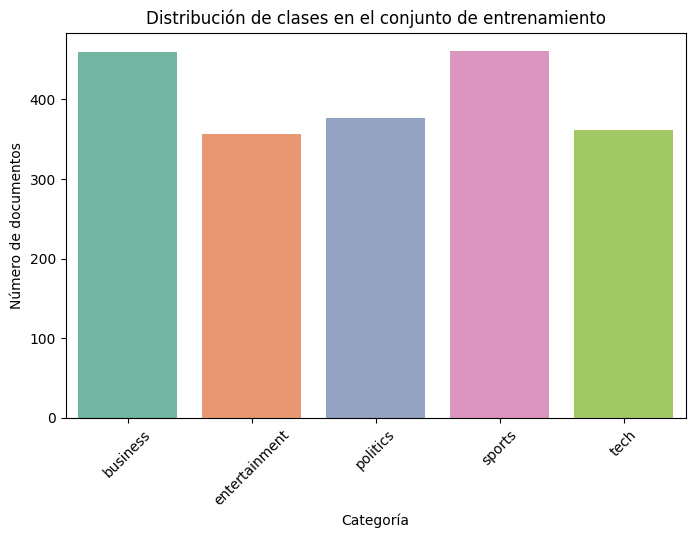

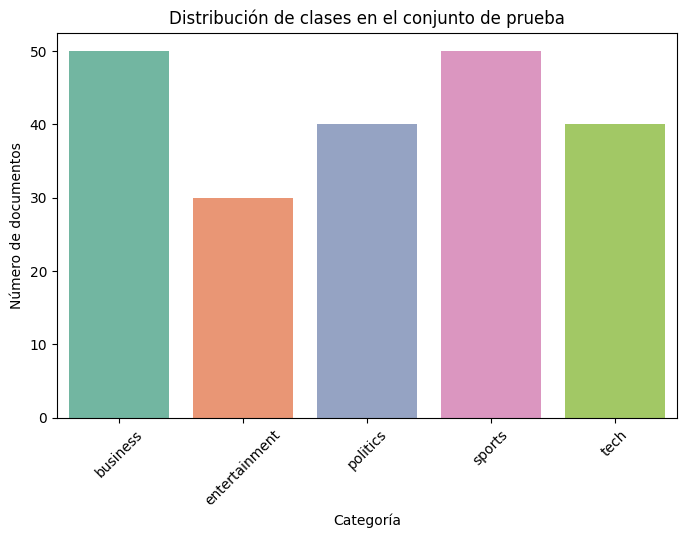

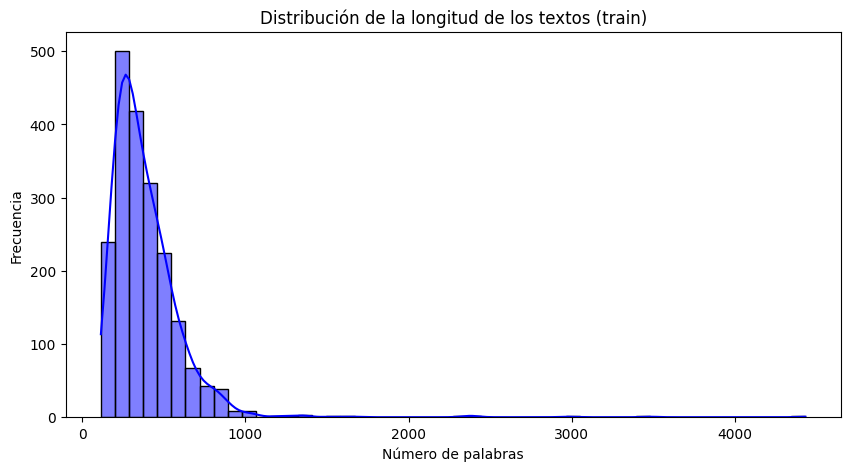

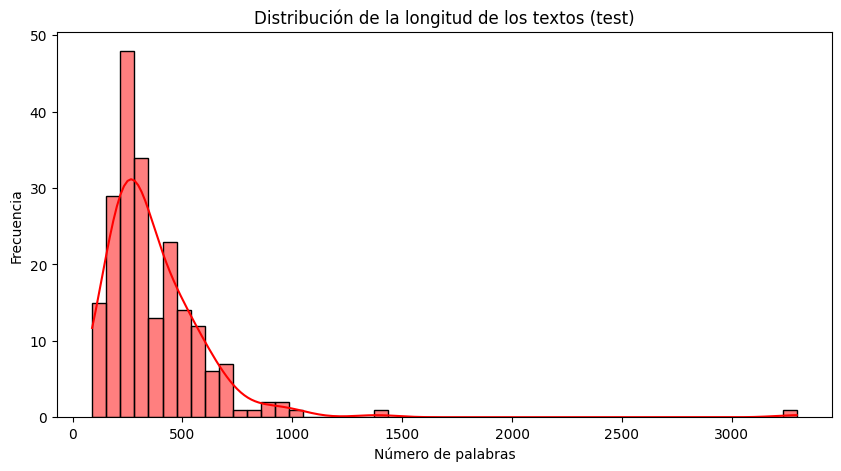

In [8]:
# Distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_train, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Distribución de clases en el conjunto de prueba
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_test, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Estadísticas básicas sobre la longitud de los textos
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribución de la longitud de los textos (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red")
plt.title("Distribución de la longitud de los textos (test)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## td-idf

In [9]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(df_train["text"])
X_test_tfidf = vectorizer.transform(df_test["text"])

# Visualización de algunas palabras más relevantes por clase
feature_names = vectorizer.get_feature_names_out()
category_keywords = {}

for category in df_train["category"].unique():
    idx = df_train[df_train["category"] == category].index
    mean_tfidf = X_train_tfidf[idx].mean(axis=0)
    sorted_indices = mean_tfidf.argsort()[0, -10:].tolist()[0]
    category_keywords[category] = [feature_names[i] for i in sorted_indices]

keywords = {f"{category}": [] for category, _ in category_keywords.items()}
for category, words in category_keywords.items():
    keywords[category] = words

pd.DataFrame(keywords).T

,0,1,2,3,4,5,6,7,8,9
business,firm,oil,mr,year,company,economy,market,bank,growth,said
entertainment,album,star,year,award,band,awards,said,music,best,film
politics,howard,minister,brown,party,government,election,blair,labour,said,mr
sports,injury,players,club,match,team,cup,win,said,game,england
tech,computer,net,digital,games,software,users,technology,mobile,said,people


## Word Embeddings Word2Vec

In [10]:
# Tokenización
df_train["tokens"] = df_train["text"].apply(lambda x: x.lower().split())

# Entrenar Word2Vec
word2vec_model = Word2Vec(sentences=df_train["tokens"], vector_size=100, window=5, min_count=5, workers=4)

# Visualizar palabras similares
word_similarities = word2vec_model.wv.most_similar("government", topn=10)
print("Palabras más similares a 'government':", word_similarities)

Palabras más similares a 'government': [('party', 0.803234338760376), ('change', 0.7991664409637451), ('tories', 0.7914888858795166), ('it', 0.7878935933113098), ('legal', 0.7839019894599915), ('site', 0.7807435989379883), ('everyone.', 0.779733419418335), ('charges,', 0.7770859003067017), ('whether', 0.7755712270736694), ('deal', 0.7753788232803345)]


## Setence Embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


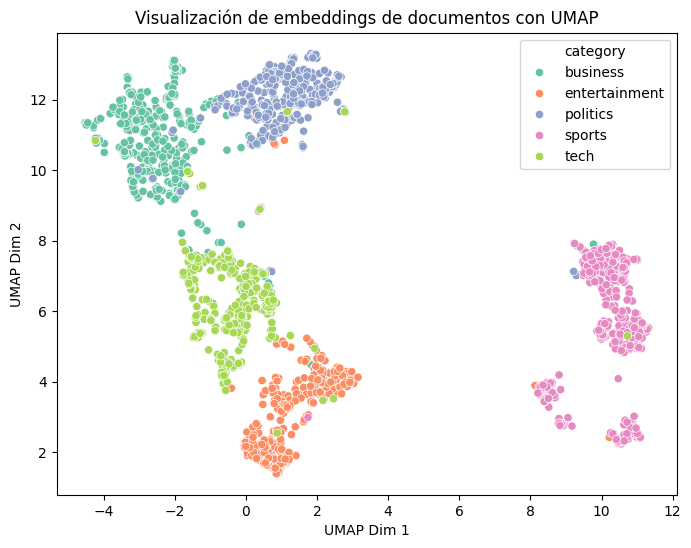

In [12]:
# Modelo de embeddings de oraciones
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generar embeddings
X_train_embeddings = model.encode(df_train["text"])
X_test_embeddings = model.encode(df_test["text"])

# Reducir dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
X_reduced = reducer.fit_transform(X_train_embeddings)

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_train["category"], palette="Set2")
plt.title("Visualización de embeddings de documentos con UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()

## LDA

In [13]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_tfidf)

# Mostrar las palabras más representativas de cada tema
for idx, topic in enumerate(lda.components_):
    print(f"Tema {df_train['category'].unique()[idx]}: {[feature_names[i] for i in topic.argsort()[-10:]]}")

Tema business: ['actor', 'ebbers', 'actress', 'awards', 'oscars', 'indoor', 'aviator', 'oscar', 'best', 'film']
Tema entertainment: ['game', 'uk', 'time', 'world', 'government', 'new', 'people', 'year', 'mr', 'said']
Tema politics: ['patent', 'search', 'mock', 'directive', 'jeeves', 'robben', 'yahoo', 'souness', 'glazer', 'mourinho']
Tema sports: ['benitez', 'lions', 'gerrard', 'gm', 'ireland', 'spyware', 'virus', 'robinson', 'england', 'yukos']
Tema tech: ['niro', 'lira', 'reliance', 'carpenter', 'reddy', 'southcorp', 'anil', 'fockers', 'commodore', 'parmalat']


# BERT (supervisado)

In [14]:
# --- Modelo Supervisado (Clasificación con BERT) ---

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(self.labels[idx])}

# Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = NewsDataset(df_train["text"].tolist(), df_train["category"].astype('category').cat.codes.tolist(), tokenizer)
test_dataset = NewsDataset(df_test["text"].tolist(), df_test["category"].astype('category').cat.codes.tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Definir métricas
def compute_metrics(eval_pred):
    metric_accuracy = load("accuracy")
    metric_f1 = load("f1")
    metric_precision = load("precision")
    metric_recall = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "precision": metric_precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": metric_recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    }

In [16]:
# Modelo BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
training_args = TrainingArguments(output_dir="./results", num_train_epochs=5, per_device_train_batch_size=8, eval_strategy="epoch")
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cdf51342 (cdf51342-universidad-carlos-iii-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.040476
2,0.186900,0.009560
3,0.186900,0.006015
4,0.013200,0.000667
5,0.013200,0.000593


TrainOutput(global_step=1260, training_loss=0.08182992424283708, metrics={'train_runtime': 1125.6753, 'train_samples_per_second': 8.95, 'train_steps_per_second': 1.119, 'total_flos': 2650915285324800.0, 'train_loss': 0.08182992424283708, 'epoch': 5.0})

In [17]:
# Evaluación del modelo en test
results = trainer.evaluate()
print("Resultados en conjunto de test:", results)

Resultados en conjunto de test: {'eval_loss': 0.0005934293731115758, 'eval_runtime': 7.2631, 'eval_samples_per_second': 28.913, 'eval_steps_per_second': 3.717, 'epoch': 5.0}


In [18]:
# Definir el directorio donde se guardará el modelo
output_dir = "./models/modelBERT"

# Guardar el modelo y el tokenizador
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modelo guardado en {output_dir}")

Modelo guardado en ./models/modelBERT


# LDA (no supervisado)

In [19]:
# --- Modelado de Temas (LDA) ---

# Crear diccionario y corpus para LDA
dictionary = corpora.Dictionary(df_train["tokens"])
corpus = [dictionary.doc2bow(text) for text in df_train["tokens"]]
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# Mostrar los temas
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.003*"s" + 0.002*"j" + 0.002*"g" + 0.002*"m" + 0.002*"d" + 0.001*"r" + 0.001*"ball" + 0.001*"ireland" + 0.001*"penalty" + 0.001*"minutes"')
(1, '0.060*"the" + 0.028*"to" + 0.023*"of" + 0.021*"and" + 0.021*"a" + 0.020*"in" + 0.010*"for" + 0.010*"is" + 0.009*"on" + 0.008*"that"')
(2, '0.001*"camera" + 0.001*"domain" + 0.001*"cabir" + 0.001*"domains" + 0.000*"computing" + 0.000*"foxx;" + 0.000*"reliance" + 0.000*"irish." + 0.000*"phones" + 0.000*"grid"')
(3, '0.062*"the" + 0.029*"to" + 0.026*"of" + 0.023*"and" + 0.020*"in" + 0.018*"a" + 0.011*"for" + 0.010*"that" + 0.010*"is" + 0.008*"by"')
(4, '0.054*"the" + 0.033*"to" + 0.019*"a" + 0.018*"of" + 0.017*"it" + 0.016*"and" + 0.015*"in" + 0.014*"that" + 0.013*"is" + 0.011*"for"')


# Almacenamiento de datos

In [24]:
df_train.to_csv('data/results/training_dataset.csv')
df_test.to_csv('data/results/testing_dataset.csv')